In [1]:
import scanpy as sc
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


In [86]:
latent = sc.read('./data/11_latent_moe.h5ad')
latent1 = sc.read('./data/11_latent_moe.h5ad')
latent2 = sc.read('./data/11_latent_moe.h5ad')
latent3 = sc.read('./data/11_latent_moe.h5ad')
adata = sc.read('./data/09_tcr_annotation_A_B_with_gender_data.h5ad')

In [87]:
sc.pp.neighbors(latent1, n_neighbors=5, method='gauss', knn=False)
sc.pp.neighbors(latent, n_neighbors=5, method='gauss', knn=False)
#sc.pp.neighbors(adata, n_neighbors=5, method='gauss', knn=False)

In [88]:
sc.tl.leiden(latent1, resolution=1)
sc.tl.leiden(latent, resolution=0.05)

In [89]:
latent2.obs['leiden'] = latent1.obs['leiden']
latent3.obs['leiden'] = latent1.obs['leiden']

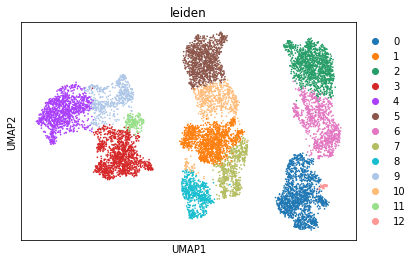

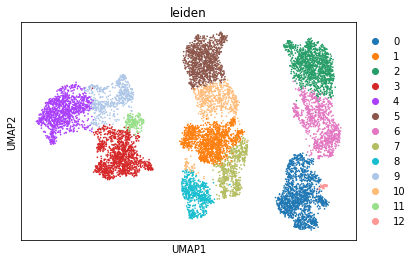

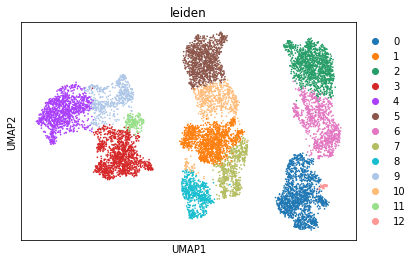

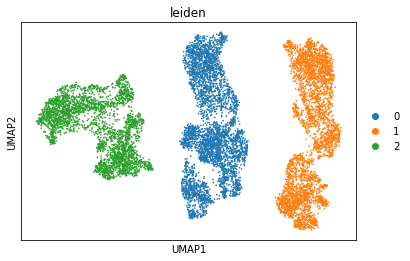

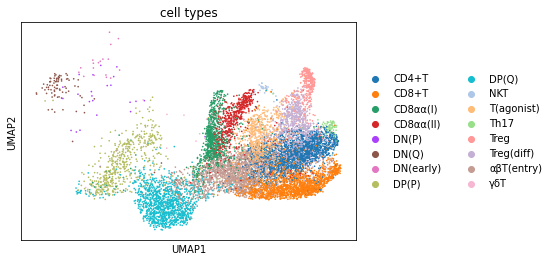

In [90]:
sc.pl.umap(latent1, color = "leiden")
sc.pl.umap(latent2, color = "leiden")
sc.pl.umap(latent3, color = "leiden")
sc.pl.umap(latent, color = "leiden")
sc.pl.umap(adata, color = "cell types")

In [91]:
#First choice of roots 
latent1.uns['iroot'] = np.flatnonzero(latent1.obs['leiden']  == '2')[0]
latent2.uns['iroot'] = np.flatnonzero(latent2.obs['leiden']  == '5')[0]
latent3.uns['iroot'] = np.flatnonzero(latent3.obs['leiden']  == '3')[0]
adata.uns['iroot'] = np.flatnonzero(adata.obs['cell types']  == 'CD8+T')[0]

In [98]:
#Second choice of roots, slightly different from the first one
latent1.uns['iroot'] = np.flatnonzero(latent1.obs['leiden']  == '2')[50]
latent2.uns['iroot'] = np.flatnonzero(latent2.obs['leiden']  == '5')[50]
latent3.uns['iroot'] = np.flatnonzero(latent3.obs['leiden']  == '3')[50]
adata.uns['iroot'] = np.flatnonzero(adata.obs['cell types']  == 'CD4+T')[50]

In [105]:
#Third choice of roots
latent1.uns['iroot'] = np.flatnonzero(latent1.obs['leiden']  == '0')[0]
latent2.uns['iroot'] = np.flatnonzero(latent2.obs['leiden']  == '8')[0]
latent3.uns['iroot'] = np.flatnonzero(latent3.obs['leiden']  == '4')[0]
adata.uns['iroot'] = np.flatnonzero(adata.obs['cell types']  == 'T(agonist)')[0]

In [112]:
#Fourth choice of roots, slightly different from the third one
latent1.uns['iroot'] = np.flatnonzero(latent1.obs['leiden']  == '0')[50]
latent2.uns['iroot'] = np.flatnonzero(latent2.obs['leiden']  == '8')[50]
latent3.uns['iroot'] = np.flatnonzero(latent3.obs['leiden']  == '4')[50]
adata.uns['iroot'] = np.flatnonzero(adata.obs['cell types']  == 'Treg')[50]

In [113]:
sc.pp.neighbors(latent1, n_neighbors=20, use_rep='X', method='gauss')
sc.tl.diffmap(latent1)
sc.tl.dpt(latent1, n_branchings=1, n_dcs=10)

sc.pp.neighbors(latent2, n_neighbors=20, use_rep='X', method='gauss')
sc.tl.diffmap(latent2)
sc.tl.dpt(latent2, n_branchings=1, n_dcs=10)

sc.pp.neighbors(latent3, n_neighbors=20, use_rep='X', method='gauss')
sc.tl.diffmap(latent3)
sc.tl.dpt(latent3, n_branchings=1, n_dcs=10)

In [114]:
sc.pp.neighbors(adata, n_neighbors=20, use_rep='X', method='gauss')
sc.tl.diffmap(adata)
sc.tl.dpt(adata, n_branchings=1, n_dcs=10)

In [115]:
latent.obs['dpt_pseudotime'] = np.zeros(latent.shape[0])
latent.obs['dpt_pseudotime'][latent.obs['leiden']=='1'] = latent1.obs['dpt_pseudotime'][latent.obs['leiden']=='1']
latent.obs['dpt_pseudotime'][latent.obs['leiden']=='0'] = latent2.obs['dpt_pseudotime'][latent.obs['leiden']=='0']
latent.obs['dpt_pseudotime'][latent.obs['leiden']=='2'] = latent3.obs['dpt_pseudotime'][latent.obs['leiden']=='2']

C:\Users\Gheorghe Pascu\AppData\Local\Temp\ipykernel_14840\28381190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latent.obs['dpt_pseudotime'][latent.obs['leiden']=='1'] = latent1.obs['dpt_pseudotime'][latent.obs['leiden']=='1']
C:\Users\Gheorghe Pascu\AppData\Local\Temp\ipykernel_14840\28381190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latent.obs['dpt_pseudotime'][latent.obs['leiden']=='0'] = latent2.obs['dpt_pseudotime'][latent.obs['leiden']=='0']
C:\Users\Gheorghe Pascu\AppData\Local\Temp\ipykernel_14840\28381190.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

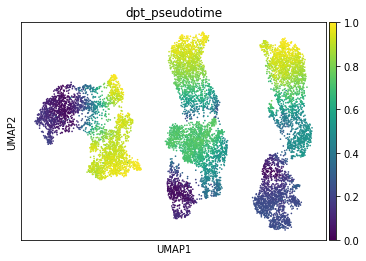

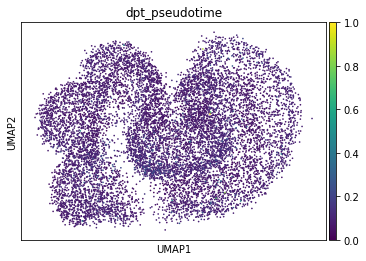

In [116]:
sc.pp.neighbors(latent, use_rep='X')
sc.tl.umap(latent)
sc.pl.umap(latent, color='dpt_pseudotime')

sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color='dpt_pseudotime')

## Results with f1_score and liblinear solver (similar results using newton-cg though)

In [117]:
k = 10
kf = KFold(n_splits=k, shuffle=True) 
model = LogisticRegression(solver = 'liblinear', tol=0.00001)
def results_cross_validation(X, y, score):
    X = X.reshape(-1,1)
    acc_score = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)

        if score == 'accuracy_score':
            acc = accuracy_score(y_true = y_test, y_pred = pred_values)
        if score == 'f1_score':
            acc = f1_score(y_true = y_test, y_pred = pred_values, average='weighted')
        acc_score.append(acc)

    avg_acc_score = sum(acc_score)/k
    return(acc_score, avg_acc_score)

In [97]:
print('Results - first choice of roots:')
print(" ")
le = LabelEncoder()

print("CELL TYPES:")
print(" ")

X1 = latent.obs['dpt_pseudotime'].to_numpy()
y1 = latent.obs['cell types'].to_numpy()
le.fit(y1)
y1 = le.transform(y1)

X2 = adata.obs['dpt_pseudotime'].to_numpy()
y2 = adata.obs['cell types'].to_numpy()
le.fit(y2)
y2 = le.transform(y2)


print("Results for f1_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'f1_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


results = results_cross_validation(X2,y2, score = 'f1_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

print(" ")
print("Results for acc_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'accuracy_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

results = results_cross_validation(X2,y2, score = 'accuracy_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


print(" ")
print("AGE:")
print(" ")

X1 = latent.obs['dpt_pseudotime'][latent.obs['Age'] != 'nan'].to_numpy()
y1 = latent.obs['Age'][latent.obs['Age'] != 'nan'].to_numpy()
le.fit(y1)
y1 = le.transform(y1)

X2 = adata.obs['dpt_pseudotime'][adata.obs['Age'] != 'nan'].to_numpy()
y2 = adata.obs['Age'][adata.obs['Age'] != 'nan'].to_numpy()
le.fit(y2)
y2 = le.transform(y2)


print("Results for f1_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'f1_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


results = results_cross_validation(X2,y2, score = 'f1_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

print(" ")
print("Results for acc_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'accuracy_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

results = results_cross_validation(X2,y2, score = 'accuracy_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

Results - first choice of roots:
 
CELL TYPES:
 
Results for f1_score:
 
Results for the latent space:
 
accuracy of each fold - [0.0810845397581456, 0.10679587699785452, 0.10392077801796873, 0.0912697238855888, 0.10867813332133493, 0.08523013883099428, 0.09392771019119023, 0.10250526642757603, 0.09508874611464099, 0.08953657849048538]
Avg accuracy : 0.09580374920357795
 
Results for the adata space:
 
accuracy of each fold - [0.12599131978694023, 0.1321968895537954, 0.11928982120938439, 0.12136221341816557, 0.13965907315487766, 0.12119815867815308, 0.13212581674235344, 0.1189439812205292, 0.12947551489242617, 0.1359493022860836]
Avg accuracy : 0.12761920909427088
 
Results for acc_score:
 
Results for the latent space:
 
accuracy of each fold - [0.2116788321167883, 0.20164233576642335, 0.20985401459854014, 0.19434306569343066, 0.19908675799086759, 0.19360730593607306, 0.21278538812785389, 0.20365296803652969, 0.2091324200913242, 0.20182648401826483]
Avg accuracy : 0.20376095723760956


In [104]:
print('Results - second choice of roots:')
print(" ")
le = LabelEncoder()

print("CELL TYPES:")
print(" ")

X1 = latent.obs['dpt_pseudotime'].to_numpy()
y1 = latent.obs['cell types'].to_numpy()
le.fit(y1)
y1 = le.transform(y1)

X2 = adata.obs['dpt_pseudotime'].to_numpy()
y2 = adata.obs['cell types'].to_numpy()
le.fit(y2)
y2 = le.transform(y2)


print("Results for f1_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'f1_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


results = results_cross_validation(X2,y2, score = 'f1_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

print(" ")
print("Results for acc_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'accuracy_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

results = results_cross_validation(X2,y2, score = 'accuracy_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


print(" ")
print("AGE:")
print(" ")

X1 = latent.obs['dpt_pseudotime'][latent.obs['Age'] != 'nan'].to_numpy()
y1 = latent.obs['Age'][latent.obs['Age'] != 'nan'].to_numpy()
le.fit(y1)
y1 = le.transform(y1)

X2 = adata.obs['dpt_pseudotime'][adata.obs['Age'] != 'nan'].to_numpy()
y2 = adata.obs['Age'][adata.obs['Age'] != 'nan'].to_numpy()
le.fit(y2)
y2 = le.transform(y2)


print("Results for f1_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'f1_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


results = results_cross_validation(X2,y2, score = 'f1_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

print(" ")
print("Results for acc_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'accuracy_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

results = results_cross_validation(X2,y2, score = 'accuracy_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

Results - second choice of roots:
 
CELL TYPES:
 
Results for f1_score:
 
Results for the latent space:
 
accuracy of each fold - [0.08741075371790157, 0.09737591033892913, 0.08799171191255259, 0.07717368507051733, 0.10872050600468247, 0.09786850518499896, 0.10319082328550425, 0.08693488567575466, 0.095260674115137, 0.09642247770749193]
Avg accuracy : 0.09383499330134698
 
Results for the adata space:
 
accuracy of each fold - [0.1048713467082977, 0.10075470467542921, 0.11541080816993225, 0.12499519064900896, 0.1222938586307887, 0.13554645021881692, 0.11208423661558278, 0.12011731781411157, 0.144903747707165, 0.13763448258899477]
Avg accuracy : 0.12186121437781279
 
Results for acc_score:
 
Results for the latent space:
 
accuracy of each fold - [0.20072992700729927, 0.19434306569343066, 0.2062043795620438, 0.20985401459854014, 0.1963470319634703, 0.2054794520547945, 0.21552511415525114, 0.17625570776255708, 0.20273972602739726, 0.18538812785388128]
Avg accuracy : 0.19928665466786658
 

In [111]:
print('Results - third choice of roots:')
print(" ")
le = LabelEncoder()

print("CELL TYPES:")
print(" ")

X1 = latent.obs['dpt_pseudotime'].to_numpy()
y1 = latent.obs['cell types'].to_numpy()
le.fit(y1)
y1 = le.transform(y1)

X2 = adata.obs['dpt_pseudotime'].to_numpy()
y2 = adata.obs['cell types'].to_numpy()
le.fit(y2)
y2 = le.transform(y2)


print("Results for f1_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'f1_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


results = results_cross_validation(X2,y2, score = 'f1_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

print(" ")
print("Results for acc_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'accuracy_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

results = results_cross_validation(X2,y2, score = 'accuracy_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


print(" ")
print("AGE:")
print(" ")

X1 = latent.obs['dpt_pseudotime'][latent.obs['Age'] != 'nan'].to_numpy()
y1 = latent.obs['Age'][latent.obs['Age'] != 'nan'].to_numpy()
le.fit(y1)
y1 = le.transform(y1)

X2 = adata.obs['dpt_pseudotime'][adata.obs['Age'] != 'nan'].to_numpy()
y2 = adata.obs['Age'][adata.obs['Age'] != 'nan'].to_numpy()
le.fit(y2)
y2 = le.transform(y2)


print("Results for f1_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'f1_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


results = results_cross_validation(X2,y2, score = 'f1_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

print(" ")
print("Results for acc_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'accuracy_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

results = results_cross_validation(X2,y2, score = 'accuracy_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

Results - third choice of roots:
 
CELL TYPES:
 
Results for f1_score:
 
Results for the latent space:
 
accuracy of each fold - [0.0926143953983207, 0.09044654659542564, 0.07695116535545728, 0.07714479629578157, 0.07654191326480986, 0.0806200454728057, 0.0708079958178962, 0.07613315648044146, 0.060283901418357454, 0.0913179474048761]
Avg accuracy : 0.0792861863504172
 
Results for the adata space:
 
accuracy of each fold - [0.09018130827329562, 0.09855013214336372, 0.08041774726181866, 0.09431426515451925, 0.0948232129348181, 0.0911110276205069, 0.0925382242051197, 0.07869494023820088, 0.10418394861544931, 0.09596610101546525]
Avg accuracy : 0.09207809074625574
 
Results for acc_score:
 
Results for the latent space:
 
accuracy of each fold - [0.1541970802919708, 0.1760948905109489, 0.16514598540145986, 0.177007299270073, 0.1771689497716895, 0.17168949771689498, 0.17442922374429223, 0.16164383561643836, 0.17534246575342466, 0.16986301369863013]
Avg accuracy : 0.17025822417758224
 
Res

In [118]:
print('Results - fourth choice of roots:')
print(" ")
le = LabelEncoder()

print("CELL TYPES:")
print(" ")

X1 = latent.obs['dpt_pseudotime'].to_numpy()
y1 = latent.obs['cell types'].to_list()
le.fit(y1)
y1 = le.transform(y1)

X2 = adata.obs['dpt_pseudotime'].to_numpy()
y2 = adata.obs['cell types'].to_numpy()
le.fit(y2)
y2 = le.transform(y2)


print("Results for f1_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'f1_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


results = results_cross_validation(X2,y2, score = 'f1_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

print(" ")
print("Results for acc_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'accuracy_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

results = results_cross_validation(X2,y2, score = 'accuracy_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


print(" ")
print("AGE:")
print(" ")

X1 = latent.obs['dpt_pseudotime'][latent.obs['Age'] != 'nan'].to_numpy()
y1 = latent.obs['Age'][latent.obs['Age'] != 'nan'].to_numpy()
le.fit(y1)
y1 = le.transform(y1)

X2 = adata.obs['dpt_pseudotime'][adata.obs['Age'] != 'nan'].to_numpy()
y2 = adata.obs['Age'][adata.obs['Age'] != 'nan'].to_numpy()
le.fit(y2)
y2 = le.transform(y2)


print("Results for f1_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'f1_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


results = results_cross_validation(X2,y2, score = 'f1_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

print(" ")
print("Results for acc_score:")
print(" ")

results = results_cross_validation(X1,y1, score = 'accuracy_score')
print("Results for the latent space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

results = results_cross_validation(X2,y2, score = 'accuracy_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))

Results - fourth choice of roots:
 
CELL TYPES:
 
Results for f1_score:
 
Results for the latent space:
 
accuracy of each fold - [0.10648782039951041, 0.11640330977831882, 0.08832679120169674, 0.10786181444669804, 0.12575075954973097, 0.10693494664802564, 0.12439896314766695, 0.11375306940149994, 0.1237184534652151, 0.10524363913199364]
Avg accuracy : 0.11188795671703562
 
Results for the adata space:
 
accuracy of each fold - [0.09066953779253827, 0.11027109784724064, 0.0924388125751263, 0.09984249321345287, 0.10425226493944213, 0.08732508403936462, 0.08026482452313075, 0.10149340229995947, 0.10923450424448367, 0.08288291676726739]
Avg accuracy : 0.09586749382420061
 
Results for acc_score:
 
Results for the latent space:
 
accuracy of each fold - [0.18248175182481752, 0.19525547445255476, 0.1843065693430657, 0.18065693430656934, 0.19269406392694063, 0.18082191780821918, 0.21187214611872146, 0.217351598173516, 0.1917808219178082, 0.20273972602739726]
Avg accuracy : 0.193996100389961


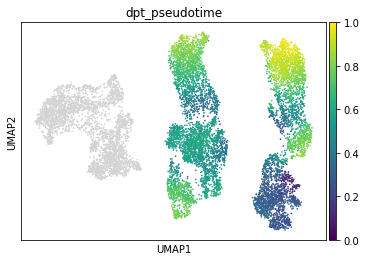

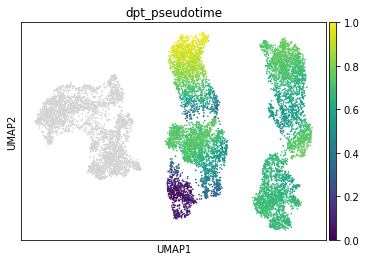

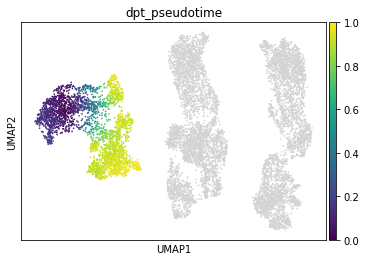

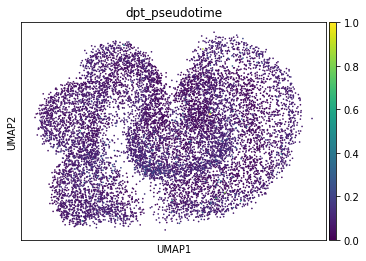

In [91]:
# sc.pp.neighbors(latent1, use_rep='X')
# sc.tl.umap(latent1)
# sc.pl.umap(latent1, color='dpt_pseudotime')

# sc.pp.neighbors(latent2, use_rep='X')
# sc.tl.umap(latent2)
# sc.pl.umap(latent2, color='dpt_pseudotime')

# sc.pp.neighbors(latent3, use_rep='X')
# sc.tl.umap(latent3)
# sc.pl.umap(latent3, color='dpt_pseudotime')

# sc.pp.neighbors(adata, use_rep='X')
# sc.tl.umap(adata)
# sc.pl.umap(adata, color='dpt_pseudotime')

In [93]:
# k = 10
# kf = KFold(n_splits=k) 
# model = LogisticRegression(solver = 'liblinear')
# def results_cross_validation(X, y, score):
#     X = X.reshape(-1,1)
#     acc_score = []
#     for train_index, test_index in kf.split(X):
#         #print("TRAIN:", train_index, "TEST:", test_index)
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         model.fit(X_train, y_train)
#         pred_values = model.predict(X_test)

#         if score == 'accuracy_score':
#             acc = accuracy_score(y_true = y_test, y_pred = pred_values)
#         if score == 'f1_score':
#             acc = f1_score(y_true = y_test, y_pred = pred_values, average='weighted')
#         acc_score.append(acc)

#     avg_acc_score = sum(acc_score)/k
#     return(acc_score, avg_acc_score)

In [94]:
# le = LabelEncoder()
# X = latent1.obs['dpt_pseudotime'][latent1.obs['leiden2']=='1'].to_numpy()
# y = latent1.obs['cell types'][latent1.obs['leiden2']=='1'].to_numpy()
# le.fit(y)
# y = le.transform(y)
# results = results_cross_validation(X,y, score = 'f1_score')
# print("Results for the latent space, blob1:")
# print(" ")
# print('accuracy of each fold - {}'.format(results[0]))
# print('Avg accuracy : {}'.format(results[1]))


# X = latent2.obs['dpt_pseudotime'][latent2.obs['leiden2']=='0'].to_numpy()
# y = latent2.obs['cell types'][latent2.obs['leiden2']=='0'].to_numpy()
# le.fit(y)
# y = le.transform(y)
# results = results_cross_validation(X,y, score = 'f1_score')
# print("Results for the latent space, blob2:")
# print(" ")
# print('accuracy of each fold - {}'.format(results[0]))
# print('Avg accuracy : {}'.format(results[1]))


# X = latent3.obs['dpt_pseudotime'][latent3.obs['leiden2']=='2'].to_numpy()
# y = latent3.obs['cell types'][latent3.obs['leiden2']=='2'].to_numpy()
# le.fit(y)
# y = le.transform(y)
# results = results_cross_validation(X,y, score = 'f1_score')
# print("Results for the latent space, blob3:")
# print(" ")
# print('accuracy of each fold - {}'.format(results[0]))
# print('Avg accuracy : {}'.format(results[1]))


# X = adata.obs['dpt_pseudotime'].to_numpy()
# y = adata.obs['cell types'].to_numpy()
# le.fit(y)
# y = le.transform(y)
# results2 = results_cross_validation(X,y, score = 'f1_score')
# print(" ")
# print("Results for the adata space:")
# print(" ")
# print('accuracy of each fold - {}'.format(results2[0]))
# print('Avg accuracy : {}'.format(results2[1]))


Results for the latent space, blob1:
 
accuracy of each fold - [0.11091173998453187, 0.10292328284866635, 0.10627330403294803, 0.21464188068232354, 0.08216545567913579, 0.09158550072103479, 0.036590942738234274, 0.08009082234619751, 0.07702702702702703, 0.0709484908637451]
Avg accuracy : 0.09731584469238443
Results for the latent space, blob2:
 
accuracy of each fold - [0.24809890546343205, 0.21334493503177387, 0.25651422725412515, 0.3886085133134325, 0.3549661371596108, 0.2966662668707911, 0.18936410997071124, 0.048594669908936086, 0.06944502705894748, 0.05373245992178031]
Avg accuracy : 0.21193352519535408
Results for the latent space, blob3:
 
accuracy of each fold - [0.2195679754273504, 0.11930052009886427, 0.21648614795166518, 0.27898479229748585, 0.2247849632659227, 0.12960795948732848, 0.05043552717374642, 0.00400130654907725, 0.010008167822913328, 0.010765598925475192]
Avg accuracy : 0.1263942958999829
 
Results for the adata space:
 
accuracy of each fold - [0.1856783622921373